C:\Users\student\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\student\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\student\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\student\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:14

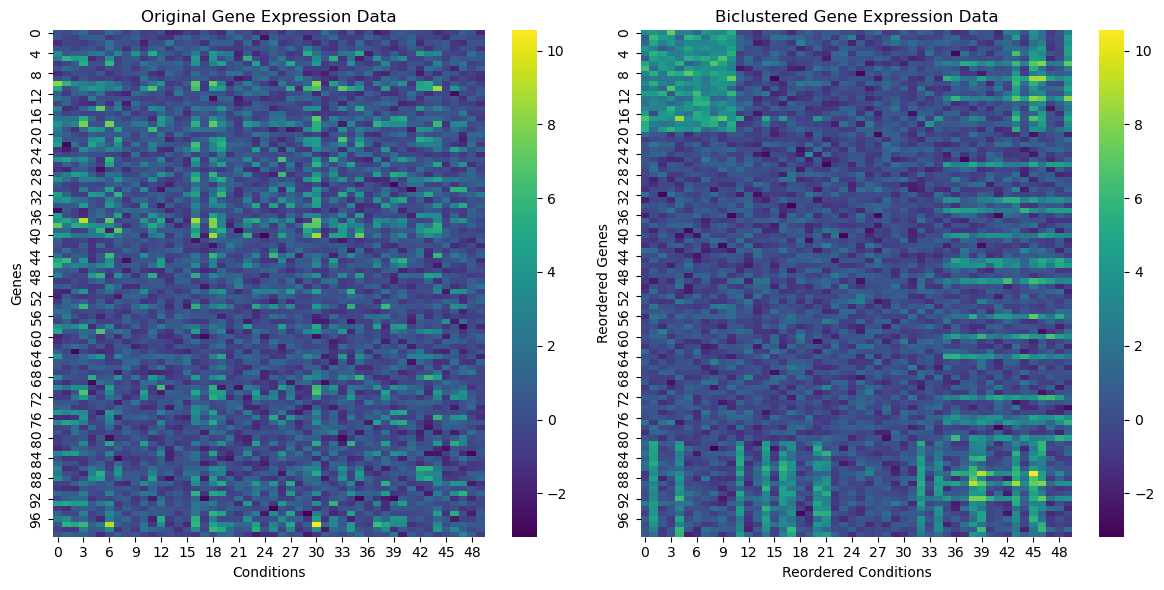

Discovered Biclusters:

Bicluster 1:
  Rows (Genes): 20 genes
  Columns (Conditions): 11 conditions

Bicluster 2:
  Rows (Genes): 20 genes
  Columns (Conditions): 24 conditions

Bicluster 3:
  Rows (Genes): 20 genes
  Columns (Conditions): 15 conditions


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralBiclustering

# 1. Generate synthetic gene expression data with known biclusters
# A real-world dataset would be read from a file, e.g., using pandas.
# This code creates a matrix representing genes (rows) and conditions (columns).
n_genes = 100
n_conditions = 50
n_biclusters = 3
noise = 0.5

# Create a base matrix of random noise
np.random.seed(42)
data_matrix = np.random.normal(size=(n_genes, n_conditions))

# Introduce distinct expression patterns for different biclusters
for i in range(n_biclusters):
    # Select random subsets of genes and conditions for each bicluster
    gene_indices = np.random.choice(n_genes, size=20, replace=False)
    cond_indices = np.random.choice(n_conditions, size=15, replace=False)
    
    # Define a high-expression pattern for the bicluster
    pattern = np.random.uniform(2, 5, size=(len(gene_indices), len(cond_indices)))
    data_matrix[np.ix_(gene_indices, cond_indices)] += pattern

# 2. Apply the biclustering algorithm
# The SpectralBiclustering model is configured to find 3 clusters.
model = SpectralBiclustering(n_clusters=n_biclusters, random_state=42)
model.fit(data_matrix)

# 3. Visualize the results
# Rearrange the matrix based on the biclustering results to show the clusters.
fit_data = data_matrix[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

# Plot the original and biclustered heatmaps
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

sns.heatmap(data_matrix, ax=ax1, cmap="viridis")
ax1.set_title("Original Gene Expression Data")
ax1.set_xlabel("Conditions")
ax1.set_ylabel("Genes")

sns.heatmap(fit_data, ax=ax2, cmap="viridis")
ax2.set_title("Biclustered Gene Expression Data")
ax2.set_xlabel("Reordered Conditions")
ax2.set_ylabel("Reordered Genes")

plt.tight_layout()
plt.show()

# 4. Interpret the output
# The 'rows_' and 'columns_' attributes of the fitted model indicate the bicluster membership.
print("Discovered Biclusters:")
for i in range(model.n_clusters):
    # Get the row and column indices for each bicluster
    row_bicluster_indices = np.where(model.rows_[i])[0]
    col_bicluster_indices = np.where(model.columns_[i])[0]
    
    print(f"\nBicluster {i+1}:")
    print(f"  Rows (Genes): {len(row_bicluster_indices)} genes")
    print(f"  Columns (Conditions): {len(col_bicluster_indices)} conditions")
    # Uncomment for detailed gene and condition lists
    # print(f"  Gene Indices: {row_bicluster_indices}")
    # print(f"  Condition Indices: {col_bicluster_indices}")


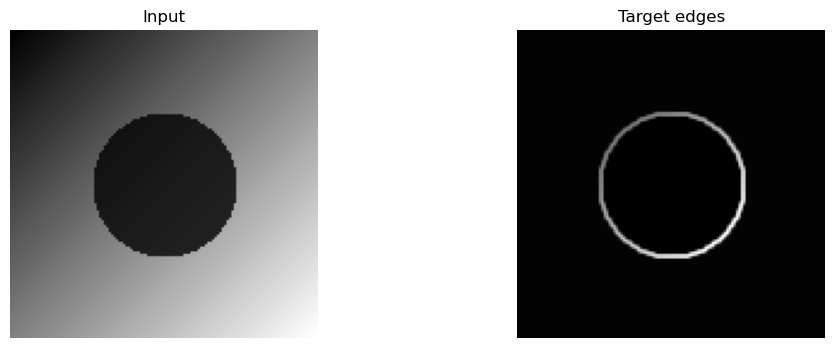

Evolving: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 185.26it/s]


Gen 0: best fitness -0.009635
Gen 5: best fitness -0.008861
Gen 10: best fitness -0.006528
Gen 15: best fitness -0.006528
Gen 20: best fitness -0.006528
Gen 25: best fitness -0.006528


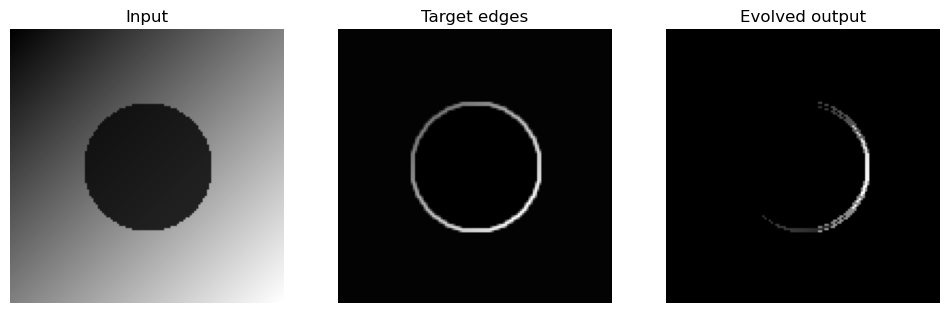

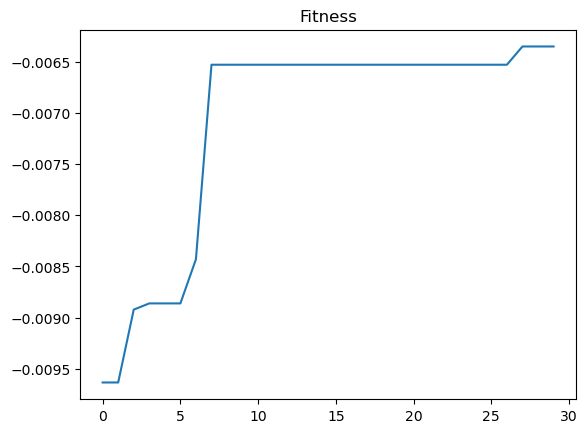

Best expression: (log((x8 add x2)) sub (abs((x0 div (x6 min (x6 add -0.864)))) max -0.931))


In [26]:
import numpy as np
import random
from PIL import Image
import matplotlib.pyplot as plt
from skimage import filters
from copy import deepcopy

# simple text progress bar
try:
    from tqdm import tqdm
    my_tqdm = tqdm
except:
    def my_tqdm(iterable, desc=None, **kwargs):
        total = len(iterable)
        for i, item in enumerate(iterable):
            if total > 0 and (i % max(1, total//10) == 0):
                print(f"{desc or ''} {i}/{total}")
            yield item

# ---------------- Utilities ----------------
def load_gray_image(path, max_size=256):
    im = Image.open(path).convert('L')
    if max(im.size) > max_size:
        scale = max_size / max(im.size)
        im = im.resize((int(im.width * scale), int(im.height * scale)))
    arr = np.array(im).astype(np.float32) / 255.0
    return arr

def show_images_grid(images, titles=None, cmap='gray', figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')
        if titles: plt.title(titles[i])
    plt.show()

def pad_image(img):
    return np.pad(img, 1, mode='edge')

def extract_neighborhoods(img):
    H, W = img.shape
    padded = pad_image(img)
    patches = np.zeros((H, W, 9), dtype=np.float32)
    idx = 0
    for dy in (-1,0,1):
        for dx in (-1,0,1):
            patches[:,:,idx] = padded[1+dy:H+1+dy, 1+dx:W+1+dx]
            idx += 1
    return patches

def pdiv(a, b): return a / (b + 1e-6)
def psqrt(a): return np.sqrt(np.abs(a))
def plog(a): return np.log(np.abs(a) + 1e-6)

UNARY_OPS = {
    'sin': np.sin,
    'cos': np.cos,
    'sqrt': psqrt,
    'abs': np.abs,
    'log': plog,
    'neg': lambda x: -x
}
BINARY_OPS = {
    'add': np.add,
    'sub': np.subtract,
    'mul': np.multiply,
    'div': pdiv,
    'max': np.maximum,
    'min': np.minimum
}
VAR_COUNT = 9

# ---------------- Genetic Expression Tree ----------------
class Node:
    def __init__(self, kind, value=None, children=None):
        self.kind = kind
        self.value = value
        self.children = children or []

    def evaluate(self, X):
        if self.kind == 'var':
            return X[:,:,self.value]
        elif self.kind == 'const':
            return np.full(X.shape[:2], self.value, dtype=np.float32)
        else:
            if self.value in UNARY_OPS:
                a = self.children[0].evaluate(X)
                return UNARY_OPS[self.value](a)
            else:
                a = self.children[0].evaluate(X)
                b = self.children[1].evaluate(X)
                return BINARY_OPS[self.value](a, b)

    def copy(self): return deepcopy(self)
    def size(self):
        if self.kind in ('var','const'): return 1
        return 1 + sum(c.size() for c in self.children)
    def to_string(self):
        if self.kind == 'var': return f"x{self.value}"
        if self.kind == 'const': return f"{self.value:.3f}"
        if self.value in UNARY_OPS:
            return f"{self.value}({self.children[0].to_string()})"
        return f"({self.children[0].to_string()} {self.value} {self.children[1].to_string()})"

def random_tree(max_depth=4, prob_var=0.6):
    if max_depth == 0 or random.random() < prob_var:
        if random.random() < 0.8:
            return Node('var', value=random.randrange(VAR_COUNT))
        else:
            return Node('const', value=random.uniform(-1,1))
    else:
        if random.random() < 0.5:
            op = random.choice(list(UNARY_OPS.keys()))
            return Node('op', value=op, children=[random_tree(max_depth-1, prob_var)])
        else:
            op = random.choice(list(BINARY_OPS.keys()))
            return Node('op', value=op, children=[random_tree(max_depth-1, prob_var),
                                                  random_tree(max_depth-1, prob_var)])

def collect_nodes(node):
    nodes = [node]
    for c in node.children: nodes.extend(collect_nodes(c))
    return nodes

def crossover(a, b):
    a2, b2 = a.copy(), b.copy()
    nodes_a, nodes_b = collect_nodes(a2), collect_nodes(b2)
    na, nb = random.choice(nodes_a), random.choice(nodes_b)
    na.kind, na.value, na.children = nb.kind, nb.value, deepcopy(nb.children)
    return a2, b2

def mutate(node, max_depth=4, prob_mut=0.2):
    node = node.copy()
    for n in collect_nodes(node):
        if random.random() < prob_mut:
            new_sub = random_tree(max_depth=max_depth)
            n.kind, n.value, n.children = new_sub.kind, new_sub.value, new_sub.children
    return node

# ---------------- Individual ----------------
class Individual:
    def __init__(self, tree=None):
        self.tree = tree if tree is not None else random_tree(max_depth=4)
        self.fitness = None
    def evaluate(self, neighborhoods):
        out = self.tree.evaluate(neighborhoods)
        return np.clip(out, -1, 1)

def fitness_mse(indiv, neighborhoods, target):
    pred = indiv.evaluate(neighborhoods)
    pred_scaled = (pred + 1) / 2.0
    return -np.mean((pred_scaled - target) ** 2)

# ---------------- Evolution ----------------
def evolve(image, target, pop_size=60, gens=40, tournament_k=3,
           cx_prob=0.6, mut_prob=0.3, elite_k=2):
    neighborhoods = extract_neighborhoods(image)
    pop = [Individual() for _ in range(pop_size)]
    for indiv in pop: indiv.fitness = fitness_mse(indiv, neighborhoods, target)
    fitness_history = []

    for g in my_tqdm(range(gens), desc="Evolving"):
        pop.sort(key=lambda x: x.fitness, reverse=True)
        newpop = pop[:elite_k]  # elitism

        while len(newpop) < pop_size:
            def select():
                return max(random.sample(pop, tournament_k), key=lambda x: x.fitness)
            p1, p2 = select(), select()
            if random.random() < cx_prob:
                c1t, c2t = crossover(p1.tree, p2.tree)
                c1, c2 = Individual(c1t), Individual(c2t)
            else:
                c1, c2 = Individual(p1.tree.copy()), Individual(p2.tree.copy())
            c1.tree = mutate(c1.tree, prob_mut=mut_prob)
            c2.tree = mutate(c2.tree, prob_mut=mut_prob)
            c1.fitness = fitness_mse(c1, neighborhoods, target)
            c2.fitness = fitness_mse(c2, neighborhoods, target)
            newpop.extend([c1, c2])
        pop = newpop[:pop_size]
        best = max(pop, key=lambda x: x.fitness)
        fitness_history.append(best.fitness)
        if g % 5 == 0: print(f"Gen {g}: best fitness {best.fitness:.6f}")
    return max(pop, key=lambda x: x.fitness), fitness_history

# ---------------- Example Run ----------------
IMAGE_PATH = None  # set to "your_image.jpg" if you want
if IMAGE_PATH:
    img = load_gray_image(IMAGE_PATH)
else:
    H = W = 128
    Y, X = np.mgrid[0:H, 0:W]
    img = (X/W*0.5 + Y/H*0.5)
    circle = (X-64)**2+(Y-64)**2 < 30**2
    img[circle] *= 0.2

target_edges = filters.sobel(img)
target_edges = (target_edges - target_edges.min()) / (target_edges.max()-target_edges.min()+1e-9)

show_images_grid([img, target_edges], ["Input", "Target edges"])

best, history = evolve(img, target_edges, pop_size=60, gens=30)

neigh = extract_neighborhoods(img)
pred = best.evaluate(neigh)
pred_scaled = np.clip((pred+1)/2, 0, 1)

show_images_grid([img, target_edges, pred_scaled], ["Input", "Target edges", "Evolved output"])
plt.plot(history); plt.title("Fitness"); plt.show()
print("Best expression:", best.tree.to_string())


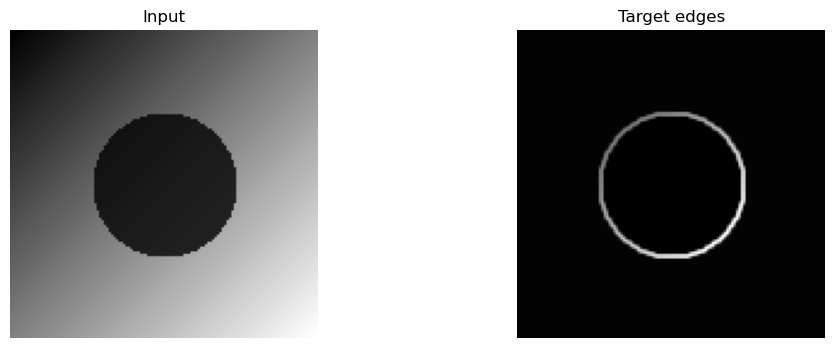

Gen 0: best fitness -0.153244
Gen 5: best fitness -0.087244
Gen 10: best fitness -0.078737
Gen 15: best fitness -0.078432
Gen 20: best fitness -0.078390
Gen 25: best fitness -0.078390


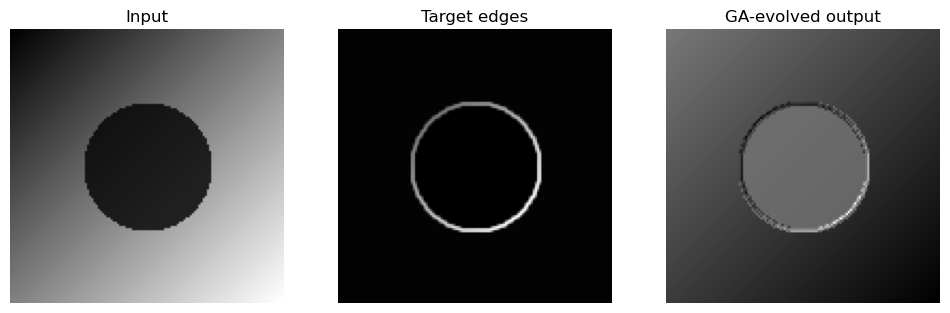

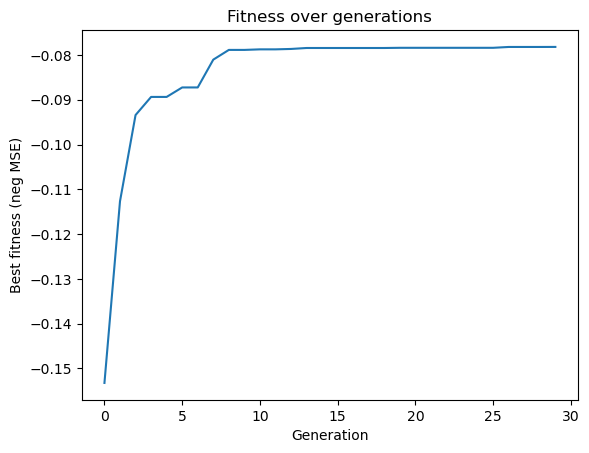

Best evolved 3x3 kernel:
 [[ 0.55159811  1.30346255 -1.26789855]
 [ 1.02355007 -0.23502549 -0.18395999]
 [-1.4535075   0.27487024 -1.22354947]]


In [27]:
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from skimage import filters
from scipy.signal import convolve2d

# ---------------- Utilities ----------------
def load_gray_image(path, max_size=256):
    im = Image.open(path).convert('L')
    if max(im.size) > max_size:
        scale = max_size / max(im.size)
        im = im.resize((int(im.width * scale), int(im.height * scale)))
    arr = np.array(im).astype(np.float32) / 255.0
    return arr

def show_images_grid(images, titles=None, cmap='gray', figsize=(12,4)):
    n = len(images)
    plt.figure(figsize=figsize)
    for i, img in enumerate(images):
        plt.subplot(1, n, i+1)
        plt.imshow(img, cmap=cmap)
        plt.axis('off')
        if titles: plt.title(titles[i])
    plt.show()

# ---------------- Genetic Algorithm ----------------
def evaluate_filter(kernel, image, target):
    kernel = kernel.reshape((3,3))
    filtered = convolve2d(image, kernel, mode="same", boundary="symm")
    filtered = (filtered - filtered.min()) / (filtered.max() - filtered.min() + 1e-9)
    return -np.mean((filtered - target) ** 2)   # negative MSE (maximize fitness)

def mutate(kernel, prob=0.2, scale=0.3):
    child = kernel.copy()
    for i in range(len(child)):
        if random.random() < prob:
            child[i] += np.random.normal(0, scale)
    return child

def crossover(p1, p2):
    point = random.randint(1, len(p1)-1)
    c1 = np.concatenate([p1[:point], p2[point:]])
    c2 = np.concatenate([p2[:point], p1[point:]])
    return c1, c2

def evolve_ga(image, target, pop_size=50, gens=40, mut_prob=0.2, elite_k=2):
    pop = [np.random.uniform(-1,1,9) for _ in range(pop_size)]
    fitness = [evaluate_filter(ind, image, target) for ind in pop]
    history = []

    for g in range(gens):
        # sort population
        pop_fit = sorted(zip(pop, fitness), key=lambda x: x[1], reverse=True)
        pop, fitness = zip(*pop_fit)
        pop, fitness = list(pop), list(fitness)

        history.append(fitness[0])
        if g % 5 == 0:
            print(f"Gen {g}: best fitness {fitness[0]:.6f}")

        # next generation
        new_pop = pop[:elite_k]   # elitism
        while len(new_pop) < pop_size:
            parents = random.sample(pop[:20], 2)  # tournament among top 20
            c1, c2 = crossover(parents[0], parents[1])
            c1 = mutate(c1, prob=mut_prob)
            c2 = mutate(c2, prob=mut_prob)
            new_pop.extend([c1, c2])
        pop = new_pop[:pop_size]
        fitness = [evaluate_filter(ind, image, target) for ind in pop]

    best = pop[np.argmax(fitness)]
    return best, history

# ---------------- Example Run ----------------
IMAGE_PATH = None  # set to "your_image.jpg" if desired

if IMAGE_PATH:
    img = load_gray_image(IMAGE_PATH)
else:
    # synthetic test image
    H = W = 128
    Y, X = np.mgrid[0:H, 0:W]
    img = (X/W*0.5 + Y/H*0.5)
    circle = (X-64)**2+(Y-64)**2 < 30**2
    img[circle] *= 0.2

target_edges = filters.sobel(img)
target_edges = (target_edges - target_edges.min()) / (target_edges.max()-target_edges.min()+1e-9)

show_images_grid([img, target_edges], ["Input", "Target edges"])

best_kernel, history = evolve_ga(img, target_edges, pop_size=50, gens=30)

# Apply best kernel
best_filtered = convolve2d(img, best_kernel.reshape(3,3), mode="same", boundary="symm")
best_filtered = (best_filtered - best_filtered.min()) / (best_filtered.max() - best_filtered.min() + 1e-9)

show_images_grid([img, target_edges, best_filtered],
                 ["Input", "Target edges", "GA-evolved output"])

plt.plot(history)
plt.title("Fitness over generations")
plt.xlabel("Generation")
plt.ylabel("Best fitness (neg MSE)")
plt.show()

print("Best evolved 3x3 kernel:\n", best_kernel.reshape(3,3))
